# PyDCM JupyterLab Notebook to fit MDCM charges from a Gaussian Cube file

In [11]:
import sys
ars_path = "/home/unibas/boittier/pydcm-1.2/"
sys.path.insert(1, ars_path)
from pydcm import *

# Setup: Define these variables for your system:
You should check and set these variables by hand for your system

In [12]:
# The Gaussian-format cube file containing electron density:
refDensCube="/home/unibas/boittier/RDKit_G2/B.pdb/OPT_B3LYP_6-31+G/B.d.cube"
# The Gaussian-format cube file containing electrostatic potential energy:
refPotCube="/home/unibas/boittier/RDKit_G2/B.pdb/OPT_B3LYP_6-31+G/B.p.cube"
# The root folder for your fitting project
projDir="/home/unibas/boittier/pydcm-1.2/models/fbutadiene-0"
# The bin directory containing the MDCM scripts and programs
refBinDir="/home/unibas/boittier/pydcm-1.2/bin"
# The total charge of the molecule to be fitted (a.u.)
qtot=0.0
# The port to use for the local web browser (to view molecules in NGL). Make sure nobody else is using it already!
webPort='8885'
# The name of a Slurm partition allowing jobs to run for up to 2 hours with 4 cores
shortQ='short'
longQ='infinite'
# The desired isodensity surface to use for viewing potential energy surfaces (a.u)
isoSurf=0.001

workdir = projDir + '/'
refdir = workdir + 'ref/'
htmldir = workdir + 'html/'
bindir = refBinDir + '/'
pdbfile = refdir + 'mol.pdb'
densCube = refdir + os.path.basename(refDensCube)
potCube = refdir + os.path.basename(refPotCube)

## Step 1: Load files and view reference ESP

### Create the desired folder structure and copy files there
This will use the "projDir" you selected as the root directory for this fitting project, copying reference files there and creating new files and subfolders as necessary.

In [13]:
coords = make_ref_directory(projDir, refBinDir, refDensCube, refPotCube)

Changed to working directory /home/unibas/boittier/pydcm-1.2/models/fbutadiene-0/
10 atoms in molecule
writing PDB file  /home/unibas/boittier/pydcm-1.2/models/fbutadiene-0/ref/mol.pdb


### Start local web server
If it worked then you should see something like "Serving HTTP on 0.0.0.0 port 8000 (http://0.0.0.0:8000/) ..." in the console where you started jupyter-lab. The port will be the webPort you set above.

In [14]:
start_server(workdir, bindir, webPort)

Running jobs:
0 : run_http()

python /home/unibas/boittier/pydcm-1.2/bin/simple-cors-http-server.py 8885
Web server running in directory /home/unibas/boittier/pydcm-1.2/models/fbutadiene-0, URLs are relative to this path
If you change the project directory, you need to restart Jupyter-Lab to restart this server and create a new root for URLs


### The next cell loads your selected reference Gaussian cube files and prepares an HTML script to plot the ESP on a molecular isodensity surface

In [15]:
display, maxESP = show_ref_models(densCube, potCube, htmldir, webPort, pdbfile, isoSurf=0.001)
display

ESP range: -0.0333205 to 0.0333205 a.u.
8885 /home/unibas/boittier/pydcm-1.2/models/fbutadiene-0/html/ /home/unibas/boittier/pydcm-1.2/models/fbutadiene-0/ref/mol.pdb
http://localhost:8885/html/refESP.html


## Step 2: Fit multipoles to reference ESP



In [16]:
mtpfile, display = display_mtpfit_comparison(workdir, bindir, htmldir, potCube, densCube, qtot, webPort, maxESP, isoSurf=0.001)
display

/home/unibas/boittier/pydcm-1.2/bin/mtpfit.py


## Step 3: Fit atomic charge models using atomic multipoles from step 2

Now the atomic multipoles are available, we can fit atomic charge models to them. This step is fast for 1 or 2 charges, but already takes up to an hour or so for 4 charges if the ESP grid you provided contains a lot of grid points (i.e. is a relatively fine or large grid)


## 1Charges Per Atom:
Atom 1 final RMSE: 1.355010146 kcal/mol
Atom 2 final RMSE: 1.177383305 kcal/mol
Atom 3 final RMSE: 3.364770865 kcal/mol
Atom 4 final RMSE: 2.648605006 kcal/mol
Atom 5 final RMSE: 3.368588735 kcal/mol
Atom 6 final RMSE: 0.7207260226 kcal/mol
Atom 7 final RMSE: 2.045873034 kcal/mol
Atom 8 final RMSE: 1.698403502 kcal/mol
Atom 9 final RMSE: 1.062961644 kcal/mol
Atom 10 final RMSE: 2.358409853 kcal/mol

## 2Charges Per Atom:
Atom 1 final RMSE: 0.9308721504 kcal/mol
Atom 2 final RMSE: 1.02541634 kcal/mol
Atom 3 final RMSE: 0.541497648 kcal/mol
Atom 4 final RMSE: 0.9886715016 kcal/mol
Atom 5 final RMSE: 0.2269288687 kcal/mol
Atom 6 final RMSE: 0.5446363614 kcal/mol
Atom 7 final RMSE: 0.8298174594 kcal/mol
Atom 8 final RMSE: 0.52990566 kcal/mol
Atom 9 final RMSE: 0.7175080928 kcal/mol
Atom 10 final RMSE: 0.7922691569 kcal/mol

## 3Charges Per Atom:
Atom 1 final RMSE: 0.2803665709 kcal/mol
Atom 2 final RMSE: 0.3501257349 kcal/mol
Atom 3 final RMSE: 0.1479215315 kcal/mol


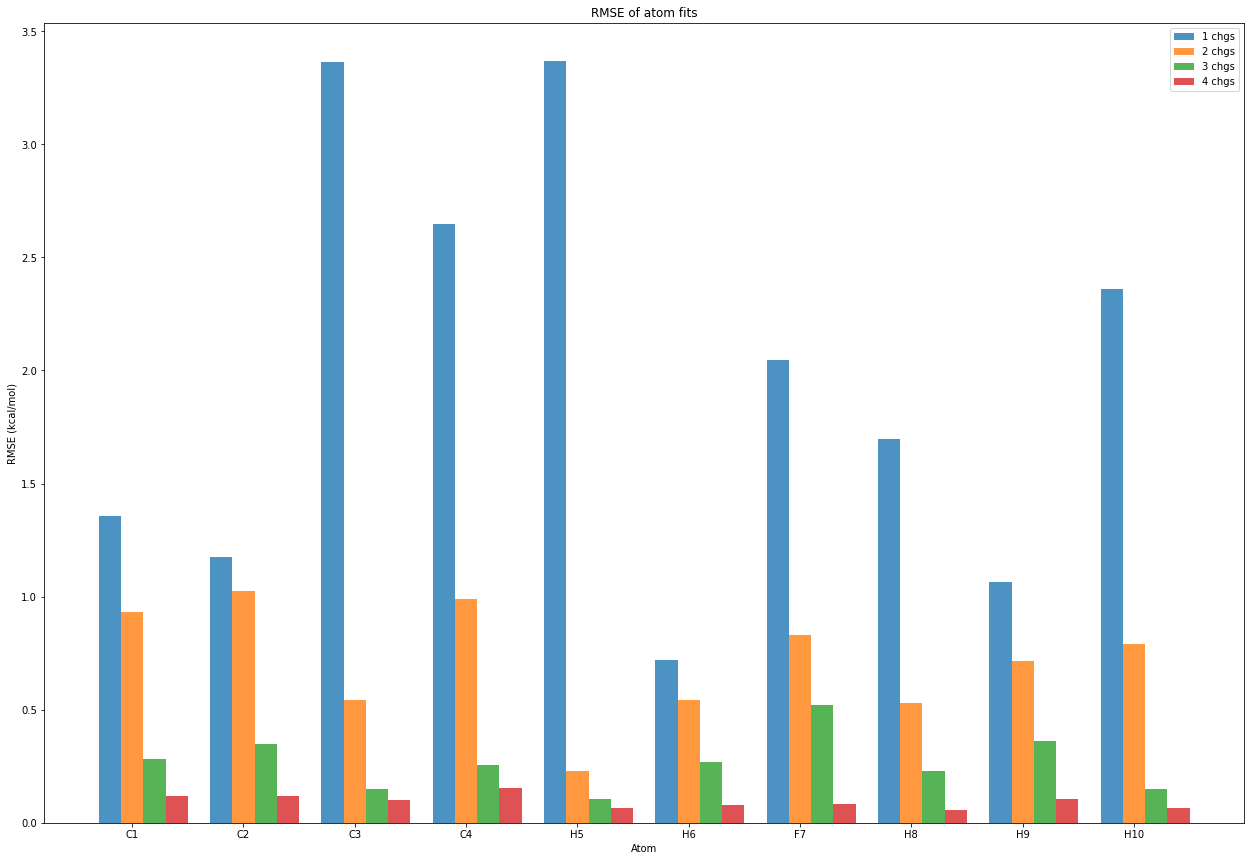

In [17]:
# Number of refinement iterations for each fit. More is better, but each fit will take longer
ntry=4
# Maximum number of charges to fit per atom (minimum is fixed at 1)
maxAChg=4

natm=10
nfrag = 4

rmse = do_atom_fit(workdir, bindir, natm, maxAChg, shortQ, mtpfile, potCube, densCube, ntry, coords, nfrag)

## Step 4: Fit fragment charge models using atomic charge models from step 3

The atomic charge models can now be used to generate an initial population for Differential Evolution fitting of fragment charge models. You need to define the fragments using their atom indices at the top of the cell (the NGL window at the top of the notebook shows the molecular structure with the atom numbers). You should also define the maximum and minimum number of charges you'd like to try per fragment. Note that you can use less than one charge on average per fragment atom if you wish, but you can't use more than maxAChg charges per atom (see previous cell for maxAChg)

In [19]:
# START OF USER VARIABLES

# Number of refinement iterations for each fit. More is better, but each fit will take longer
ntry=4
# Number of separate fits to perform (restarting a fit can lead to a better outcome). Cost scales linearly
nfit=2
# Define fragments using atom numbering from NGL window at top of notebook
frags=[[9, 10, 4],[3,8],[7,2],[5,1,6]]
# Minimum number of charges to fit for each fragment (can average fewer than 1 per atom)
minFChg=[3,2,2,3]
# Maximum number of charges to fit for each fragment (upper limit per atom fixed by maxAChg)
maxFChg=[12,8,8,12]

atomdir=workdir+'2-atomfit/'

fit_fragments(workdir, frags, nfit, natm, maxAChg, atomdir, minFChg, 
                  maxFChg, longQ, bindir, refdir, mtpfile, potCube,
                   densCube, ntry, htmldir, webPort, pdbfile)

Frag 1 fit 1, 6 charges: Job 38333083 is still running
Frag 1 fit 1, 7 charges: Job 38333084 is still running
Frag 1 fit 1, 8 charges: Job 38333085 is still running
Frag 1 fit 1, 9 charges: Job 38333086 is still running
Frag 1 fit 1, 10 charges: Job 38333087 is still running
Frag 1 fit 1, 11 charges: Job 38333088 is still running
Frag 1 fit 1, 12 charges: Job 38333089 is still running
Frag 1 fit 1, 13 charges: Job 38333090 is still running
Frag 1 fit 2, 6 charges: Job 38333093 is still running
Frag 1 fit 2, 7 charges: Job 38333094 is still running
Frag 1 fit 2, 8 charges: Job 38333095 is still running
Frag 1 fit 2, 9 charges: Job 38333096 is still running
Frag 1 fit 2, 10 charges: Job 38333097 is still running
Frag 1 fit 2, 11 charges: Job 38333098 is still running
Frag 1 fit 2, 12 charges: Job 38333099 is still running
Frag 1 fit 2, 13 charges: Job 38333100 is still running
Frag 2 fit 1, 6 charges: Job 38333104 is still running
Frag 2 fit 1, 7 charges: Job 38333105 is still running
Fr

IndexError: list index out of range

## Step 5: Combine fragments to build a molecular model

In this step for each desired total number of charges for the whole molecule, all possible permutations of the fragment models are combined to find the lowest RMSE. For example, if there are 2 fragments and we request 6 charges for the molecule then we can try 5 charges from fragment 1 and 1 charge from fragment 2, or 4 charges from fragment 1 and 2 charges from fragment 2 and so on. Note that the RMSE is just an estimate based on the individual RMSEs of the fragments.

In [ ]:
minMChg=18
maxMChg=54

combine_fragements(workdir, minMChg, maxMChg, minFChg, maxFChg, 
                   frags, bindir, nfit, fragdir, htmldir, pdbfile, webPort):
    

## Step 6: Refine molecular models

In this step the molecular models produced by combining fragment MDCMs are refined in a final simplex opimization

In [ ]:
refine_models(workdir,  maxMChg , minMChg, combdir, longQ,
                  bindir, mtpfile, potCube, densCube, maxAChg, webPort, pdbfile)

## Step 6: Analysis

In this step individual models can be examined in detail in terms of their performance compared to different multipole models with visualization of the ESP surface.

In [ ]:
nchg = 30
#
analyse_model(workdir, refinedir, nchg, mtpdir, bindir, potCube, densCube, qtot, htmldir, webPort, isoSurf=0.001) 

## Step 7: Export to CHARMM

In this step the models can be exported in a format to be read by CHARMM's "DCM" module, defining charge positions relative to local axes to allow molecular dynamics simulation or energy calculations after conformational change.

In [ ]:

# cd /home/unibas/boittier/pydcm-1.2/test2/
#python ~/get_frames.py ref/mol.pdb LIG
# cd /home/unibas/boittier/pydcm-1.2/test2/7-to-charmm
#../../bin/comb-xyz-to-dcm.pl ../5-refine/30-charges/30_charges_refined.xyz ../ref/N.p.cube ../../frame.txt butone-cf3-eq.dcm 
